In [22]:
import numpy as np
import pandas as pd
from __future__ import division
import time
from random import shuffle
import xmltodict
import json
import collections
from collections import Counter

import nltk
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from gensim.models import LdaModel
from gensim.corpora import Dictionary

# view all columns of pandas df
pd.set_option('display.max_columns', None)

# nltk.download('wordnet')      # download wordnet if it's not already downloaded
# nltk.download('averaged_perceptron_tagger')

with open ("dreambank-public.xml") as f:
    doc = xmltodict.parse(f.read())

def convert(data):
    if isinstance(data, basestring):
        return str(data)
    elif isinstance(data, collections.Mapping):
        return dict(map(convert, data.iteritems()))
    elif isinstance(data, collections.Iterable):
        return type(data)(map(convert, data))
    else:
        return data

def left(s, amount):
    return s[:amount]

def right(s, amount):
    return s[-amount:]

def mid(s, offset, amount):
    return s[offset:offset+amount]

# Exploratory Analysis

First we want to print the data to see which fields we are given and how the data looks.

In [23]:
for dreamer in doc['dreambank']['collection']:
    print dreamer['name'] + ' (' + str(len(dreamer['dream'][:])) + ' dreams)' 
    print '  ID: ' + dreamer['id']
    print '  type: ' + dreamer['type']
    print '  sex: ' + dreamer['sex']
    print '  age: ' + dreamer['age']
    
    try:
        print '  time: ' + dreamer['time']
    except:
        pass
    
    print '  sample dream: ' 
    
    odict = dreamer['dream'][0]
    for key, value in odict.items():
        if convert(key) == 'report':
            print '    report: ' + left(convert(value), 200) + '...'
        else:
            print '    ' + convert(key) + ': ' + str(convert(value))
        
    print '\n'

Alta: a detailed dreamer (422 dreams)
  ID: alta
  type: series
  sex: F
  age: A
  time: 1985-1997
  sample dream: 
    number: 1
    date: 1957
    report: The one at the Meads's house, where it's bigger inside than out; there's a European village just inside, with a cobblestone street and a Pied-Piper sort of man with curly hair, he can do things like j...


Angie: age 18 & 20 (48 dreams)
  ID: angie
  type: series
  sex: F
  age: Y
  time: 1996
  sample dream: 
    number: 1-01
    date: 1996-04-03
    report: My memory of this dream is vague. I think the setting is on a college campus. I'm in a cafe and two elderly ladies walk in and start talking to me about a university that a guy I am dating got into fo...


Arlie: a middle-aged woman (212 dreams)
  ID: arlie
  type: series
  sex: F
  age: A
  time: 1992-1998
  sample dream: 
    number: 1
    date: 10/14/92
    report: I am in an office in the town next to the town I grew up in. Everyone is taking a rest. I have to go to the b

In [24]:
print '---Dream collections from individuals---' + '\n'
MultIDs = ['b', 'madeline1-hs', 'madeline2-dorms', 'madeline3-offcampus', 'phil1', 'phil2', 'vietnam_vet']
NumberOfSeries = 1

for dreamer in doc['dreambank']['collection']:
    if dreamer['type'] == 'series':
        print '{' + dreamer['id']  + '} ' + dreamer['name'] + ' (' + str(len(dreamer['dream'][:])) + ' dreams)' + ' [' + dreamer['sex'] + ']'    
        dreamer['w266ID'] = NumberOfSeries
        
        # Assign a dreamer ID that groups the same dreamers together 
        # and skips the dream collections of multiple dreamers
        print 'w266 ID: ' + str(dreamer['w266ID'])
        if dreamer['id'] not in MultIDs:
            print '\n'
            NumberOfSeries += 1
    else:
        dreamer['w266ID'] = 0
        
print "Total Number of individuals to test vs. 'others': " + str(NumberOfSeries - 1)

---Dream collections from individuals---

{alta} Alta: a detailed dreamer (422 dreams) [F]
w266 ID: 1


{angie} Angie: age 18 & 20 (48 dreams) [F]
w266 ID: 2


{arlie} Arlie: a middle-aged woman (212 dreams) [F]
w266 ID: 3


{b} Barb Sanders (3116 dreams) [F]
w266 ID: 4
{b2} Barb Sanders #2 (1138 dreams) [F]
w266 ID: 4


{bosnak} Robert Bosnak: A dream analyst (53 dreams) [M]
w266 ID: 5


{chris} Chris: a transvestite (100 dreams) [M]
w266 ID: 6


{chuck} Chuck: a physical scientist (75 dreams) [M]
w266 ID: 7


{dahlia} Dahlia: concerns with appearance (24 dreams) [F]
w266 ID: 8


{david} David: teenage dreams (166 dreams) [M]
w266 ID: 9


{dorothea} Dorothea: 53 years of dreams (900 dreams) [F]
w266 ID: 10


{ed} Ed: dreams of his late wife (143 dreams) [M]
w266 ID: 11


{edna} Edna: a blind woman (19 dreams) [F]
w266 ID: 12


{elizabeth} Elizabeth: a woman in her 40s (1707 dreams) [F]
w266 ID: 13


{emma} Emma: 48 years of dreams (1521 dreams) [F]
w266 ID: 14


{emmas_husband} Emma's

In [25]:
DreamNum = 0

for dreamer in doc['dreambank']['collection']:
    for odict in dreamer['dream']:
        for key, value in odict.items():            
            if convert(key) == 'report':
                DreamNum += 1

print "Total Dreams: " + str(DreamNum)

Total Dreams: 26000


# EDA - Reduce To Noun-Only And Lemmatize

For our topic modeling, we will want to lemmatize the corpus and reduce to nouns-only. However, before we get to topic modeling, it will be helpful to test out the lemmatization and noun-only reduction techniques.

In [26]:
# reduce to noun-only and lemmatize

lmtzr = WordNetLemmatizer()

for dreamer in doc['dreambank']['collection']:
    print dreamer['name'] + ' (' + str(len(dreamer['dream'][:])) + ' dreams)' + ' [' + dreamer['sex'] + ']'
    
    print '  noun-only sample dream: ' 
    
    odict = dreamer['dream'][0]
    
    # (1) tokenize dream text
    # (2) tag with PoS
    # (3) reduce to noun-only
    # (4) lemmatize nouns
    # (5) get frequency counts of the lemmatized nouns
    for key, value in odict.items():
        if convert(key) == 'report':
            text = nltk.tokenize.word_tokenize(value)
            pos = nltk.pos_tag(text)
            noun_only = [w[0] for w in pos if w[1].startswith('N')]
            lmtz_noun_only = [lmtzr.lemmatize(word) for word in noun_only]
            counts = Counter(lmtz_noun_only)
            print counts
        
    print '\n'

Alta: a detailed dreamer (422 dreams) [F]
  noun-only sample dream: 
Counter({u'house': 3, u'hair': 2, u'[': 2, u'room': 2, u'bridge': 1, u'set': 1, u'creek': 1, u'people': 1, u'stove': 1, u'one': 1, u'street': 1, u'village': 1, u'corner': 1, u'blonde': 1, u'string': 1, u'pageboy': 1, u'balloon': 1, u'juggle': 1, u'couple': 1, u'sort': 1, u'hallway': 1, u'woman': 1, u'Meads': 1, u'Inside': 1, u'cobblestone': 1, u']': 1, u'man': 1, u'drive': 1, u'round': 1, u'thing': 1, u'aunt': 1, u'side': 1})


Angie: age 18 & 20 (48 dreams) [F]
  noun-only sample dream: 
Counter({u'dream': 3, u'school': 2, u'guy': 2, u'lady': 2, u'hospital': 1, u'information': 1, u'feeling': 1, u'art': 1, u'orientation': 1, u'university': 1, u'cafe': 1, u'setting': 1, u'college': 1, u'memory': 1, u'law': 1, u'campus': 1})


Arlie: a middle-aged woman (212 dreams) [F]
  noun-only sample dream: 
Counter({u'town': 2, u'toilet': 2, u'bathroom': 1, u'Everyone': 1, u'office': 1, u'rest': 1})


Barb Sanders (3116 dreams) [F

Counter({u'house': 2, u'Shirkan': 2, u'tiger': 1, u'microphone': 1, u'radio': 1})


Merri: an artist (315 dreams) [F]
  noun-only sample dream: 
Counter({u'window': 4, u'Chinatown': 3, u'sister': 3, u'corner': 2, u'girl': 2, u'picture': 2, u'time': 2, u'lantern': 2, u'Canal': 1, u'scam': 1, u'show': 1, u'South': 1, u'house': 1, u'St.': 1, u'desk': 1, u'yellow': 1, u'hair': 1, u'paper': 1, u'comma': 1, u'experience': 1, u'Carlos': 1, u'thick': 1, u'cell': 1, u'space': 1, u'TV': 1, u'top': 1, u'sky': 1, u'factory': 1, u'sunlight': 1, u'William': 1, u'sparkle': 1, u'Dora': 1, u'Joe': 1, u'prison': 1, u'inch': 1, u'bubble': 1, u'roll': 1, u'board': 1, u'junk': 1, u'door': 1, u'building': 1, u'staircase': 1, u'word': 1, u'ladder': 1, u'sunshine': 1, u'cement': 1, u'child': 1, u'foot': 1, u'stapler': 1, u'card': 1, u'shoulder': 1, u'Golden': 1, u'towel': 1, u'stranger': 1, u'hour': 1, u'artist': 1, u'Fong': 1, u'car': 1, u'roof': 1, u'drawing': 1, u'street': 1, u'wrench': 1, u'guy': 1, u'sid

# Create Dataframe

In [27]:
ID = 0
W266ID = 0
DreamBankID = ''
DreamNumber = ''
Name = ''
Sex = ''
Dream = ''
HasDream = 0

df = pd.DataFrame(columns=["ID", "W266ID", "DreamBankID", "DreamNumber", "Name", "Sex", "Dream"])

for dreamer in doc['dreambank']['collection']:
    Name = dreamer['name'] 
    DreamBankID = dreamer['id']
    W266ID = int(dreamer['w266ID'])
    Sex = dreamer['sex']
    
    for odict in dreamer['dream']:
        HasDream = 0
        for key, value in odict.items():
            if convert(key) == 'report':
                Dream = convert(value)
                HasDream = 1
            if convert(key) == 'number':
                DreamNumber = convert(value)
        
        if HasDream == 1:
            ID += 1
            df = df.append({
                "ID": ID,
                "W266ID": W266ID,
                "DreamBankID": DreamBankID,
                "DreamNumber": DreamNumber,
                "Name": Name,
                "Sex": Sex,
                "Dream": Dream
                }, ignore_index=True)        

# change W266ID from float to integer
df.W266ID = df.W266ID.astype(int)

# print df
print "Total Dreams: " + str(ID)
print "\n"

df.head()

Total Dreams: 26000




,ID,W266ID,DreamBankID,DreamNumber,Name,Sex,Dream
0,1,1,alta,1,Alta: a detailed dreamer,F,"The one at the Meads's house, where it's bigge..."
1,2,1,alta,2,Alta: a detailed dreamer,F,I'm at a family reunion in a large fine house ...
2,3,1,alta,3,Alta: a detailed dreamer,F,I watch a plane fly past and shortly realize i...
3,4,1,alta,4,Alta: a detailed dreamer,F,Me pulling the green leaves and berries off so...
4,5,1,alta,5,Alta: a detailed dreamer,F,I'm in a room that reminds me of (but definite...


130 dreams for Dreamer #40
Counter({'man': 72, 'one': 65, 'see': 57, 'us': 53, 'like': 50, 'go': 46, 'dream': 41, 'large': 39, 'back': 39, 'small': 36, 'ends': 36, 'tell': 35, 'wake': 35, 'begin': 33, 'say': 30, 'fire': 29, 'though': 28, 'brother': 28, 'Recollection': 27, 'time': 27, 'two': 27, 'another': 27, 'walk': 27, 'men': 26, 'old': 26, 'people': 26, 'away': 25, 'war': 25, 'point': 25, 'young': 25, 'want': 24, 'ground': 24, 'woman': 24, 'get': 23, 'Vietnam': 23})


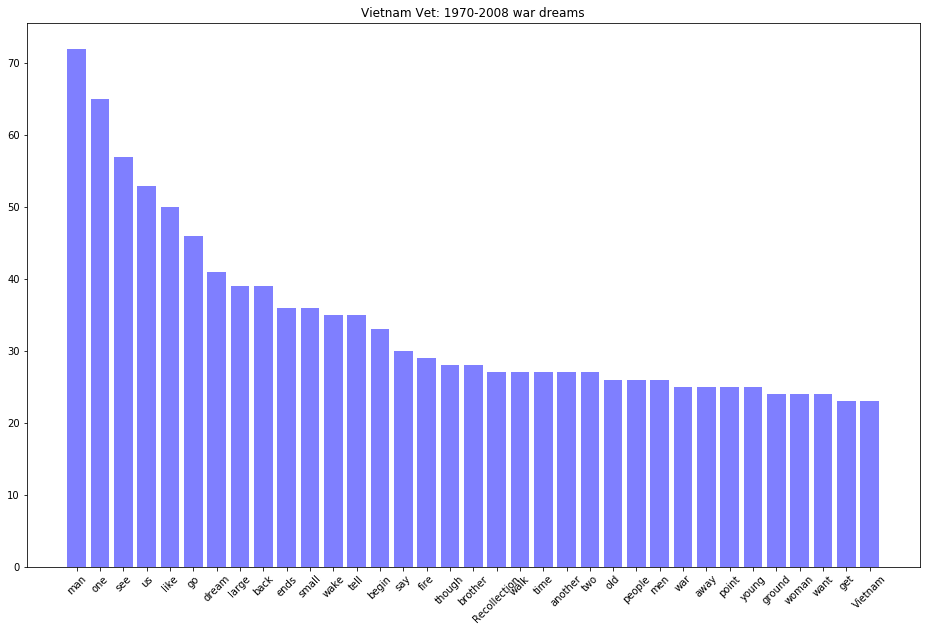

In [170]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

df2 = pd.DataFrame(columns=["ID", "W266ID", "DreamBankID", "DreamNumber", "Name", "Sex", "Dream"])

DreamerID = 40
df2 = df.loc[df['W266ID'] == DreamerID]
             
df2.head()

print str(len(df2['Dream'])) + ' dreams for Dreamer #' + str(DreamerID)
dreams = df2['Dream']

dreamsgraph = " ".join(dreams)        
dreamsgraph = list(nltk.tokenize.word_tokenize(dreamsgraph))
dreamsgraph = [word for word in dreamsgraph if word.lower() not in stopwords.words('english')]
dreamsgraph = [word for word in dreamsgraph if word not in \
               ["=", "3", "2", "/I", "&", "nbsp", "...", "'", '<', '>', 'BR', ':', '!', '--', 'X.', 'ca', 'x94', 'x92t', 'ti', 'x92d', 'x92s', 'x85', ',', 'I', '.', "'s", '-', "'m", "n't", '(', ')', '[', ']', ';', 'The', "'re", "'ve", '?', "''", "``", "'ll", "'d"]]

counts = Counter(dreamsgraph)
biggestcount = counts.most_common(1)[0][1]
for k in list(counts):
    if counts[k] < biggestcount/4 + 5  :
        del counts[k]

print counts

labels, values = zip(*counts.items())        

# sort in descending order
indSort = np.argsort(values)[::-1]

labels = np.array(labels)[indSort]
values = np.array(values)[indSort]
indexes = np.arange(len(labels))

plt.title(df2['Name'].iloc[0]) 
plt.bar(indexes, values, align='center', alpha=0.5, color='blue')
plt.xticks(indexes, labels, rotation=45) #+ bar_width

# Get current size
fig_size = plt.rcParams["figure.figsize"]
# print "Current size:", fig_size

# Set figure width to 12 and height to 9
fig_size[0] = 16
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

plt.show()


In [87]:
#print df2['Name'].iloc[0]
print counts.most_common(1)[0][1]

990


In [28]:
print 'Males: ' + str(len(df[df['Sex']=='M']))
print 'Females: ' + str(len(df[df['Sex']=='F']))
print 'Total: ' + str(len(df))

Males: 7813
Females: 18187
Total: 26000


# Modeling

We want to create a different model for each dreamer (i.e. a classifier identifying one vs all-others for each dreamer). This will allow us to identify the most predictive words in identifying each dreamer.

In [29]:
# randomly shuffle dataframe
# set seed for consistency while running
np.random.seed(0)
df = df.sample(frac=1).reset_index(drop=True)

# add 41 flag columns denoting dreamers (one col per dreamer) 
dreamer_flag = pd.get_dummies(df['W266ID'], prefix='Dreamer')
df = pd.concat([df, dreamer_flag], axis=1)

# create vocab from all dreams
dreams_flat = df['Dream'].values.flatten().tolist()
dreams_list = " ".join(dreams_flat)
vocab = list(set(nltk.tokenize.word_tokenize(dreams_list)))

In [30]:
def split_data(df, W266ID, train=0.6):        
    # column for "our" dreamer
    dreamer_label = 'Dreamer_' + str(W266ID)
    
    # make 60/40 split of train/test
    # test will be evenly split between dev and test in the next step
    num_train = int(len(df) * train)
    num_test = int(len(df) * (1-train)) 

    train_data, train_labels = df['Dream'][:num_train], df[dreamer_label][:num_train]
    dev_data, dev_labels = df['Dream'][-num_test : -num_test//2], df[dreamer_label][-num_test : -num_test//2] 
    test_data, test_labels = df['Dream'][-num_test//2:], df[dreamer_label][-num_test//2:]

    return train_data, train_labels, dev_data, dev_labels, test_data, test_labels

In [31]:
# # split data for dreamer1 - Alta
# train_data, train_labels, dev_data, dev_labels, test_data, test_labels = split_data(df, W266ID=1)
    
# # Create a Bag-of-Words Vectorizer
# vec = CountVectorizer(vocabulary=vocab)
# vec_bow_train_data = vec.fit_transform(train_data)
# vec_bow_dev_data = vec.transform(dev_data)  

# # Create a Tfidf Vectorizer
# vec_tfidf = TfidfVectorizer(stop_words='english')
# vec_tfidf_train_data = vec_tfidf.fit_transform(train_data)
# vec_tfidf_dev_data   = vec_tfidf.transform(dev_data)

# best_lr_score = 0

# ## Logistic reg
# for c in (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500):
#     bow_log = LogisticRegression(C = c)
#     bow_log.fit(vec_bow_train_data, train_labels)
    
#     tfidf_logit_model = LogisticRegression(C=c)
#     tfidf_logit_model.fit(vec_tfidf_train_data, train_labels)
    
#     f1_bow_lr_score = metrics.f1_score(dev_labels, bow_log.predict(vec_bow_dev_data), average='macro')    
#     f1_tfidf_lr_score = metrics.f1_score(dev_labels, tfidf_logit_model.predict(vec_tfidf_dev_data), average='macro') 

#     print 'Logistic Reg:\t C=%3.4f\t BOW: F1-score=%3.3f\t TFIDF: F1-score=%3.3f' % (c, f1_bow_lr_score, f1_tfidf_lr_score)

#     if f1_bow_lr_score > best_lr_score:
#         best_lr_score = f1_bow_lr_score
#         best_C = c 
#         vectorizer = 'BOW'
        
#     if f1_tfidf_lr_score > best_lr_score:
#         best_lr_score = f1_tfidf_lr_score
#         best_C = c
#         vectorizer = 'TFIDF'

# print ''
# print 'Best model:\t C=%3.4f\t vectorizer = %s\t F1-score=%3.3f' % (best_C, vectorizer, best_lr_score)

## Run a model for each dreamer

We need to run a separate model for each dreamer. The models will predict if a dream comes from that dreamer or from "all-others". Since bag-of-words was working best in the above models, we will continue to use that for our baseline.

In [32]:
# Run Logisitic Regression for each dreamer
cell_start = time.time()

models = {}

for i in range(0,41):
    # split data
    train_data, train_labels, dev_data, dev_labels, test_data, test_labels = split_data(df, W266ID=i)
    print "Progression: Logistic Regression for dreamer ", i
    # Create a Bag-of-Words Vectorizer
    vec_bow = CountVectorizer(vocabulary=vocab)
    vec_bow_train_data = vec_bow.fit_transform(train_data)
    vec_bow_dev_data = vec_bow.transform(dev_data)  
    
    # Create a TF Vectorizer
    vec_tf = TfidfTransformer(use_idf=False, smooth_idf=False)
    vec_tf_train_data = vec_tf.fit_transform(vec_bow_train_data)
    vec_tf_dev_data   = vec_tf.transform(vec_bow_dev_data)     

    # Create a TF-IDF Vectorizer
    vec_tfidf = TfidfVectorizer(stop_words='english')
    vec_tfidf_train_data = vec_tfidf.fit_transform(train_data)
    vec_tfidf_dev_data   = vec_tfidf.transform(dev_data)    

    ## Logistic reg
    bow_log = LogisticRegression(C = 100)
    bow_log.fit(vec_bow_train_data, train_labels)

    tf_log = LogisticRegression(C = 100)
    tf_log.fit(vec_tf_train_data, train_labels)
    
    tfidf_log = LogisticRegression(C = 100)
    tfidf_log.fit(vec_tfidf_train_data, train_labels)    
    
    # score models
    f1_bow = metrics.f1_score(dev_labels, bow_log.predict(vec_bow_dev_data), average='macro')
    f1_tf = metrics.f1_score(dev_labels, tf_log.predict(vec_tf_dev_data), average='macro')    
    f1_tfidf = metrics.f1_score(dev_labels, tfidf_log.predict(vec_tfidf_dev_data), average='macro')

    # find the most-predictive features
    ### we're not using the weights currently, but might be useful/interesting later ###    
    best_feature_positions_bow = bow_log.coef_.argsort()[0][-5::]
    best_feature_weights_bow = bow_log.coef_[0][best_feature_positions_bow.astype(int)]
    
    best_feature_positions_tf = tf_log.coef_.argsort()[0][-5::]
    best_feature_weights_tf = tf_log.coef_[0][best_feature_positions_tf.astype(int)]  
    
    best_feature_positions_tfidf = tfidf_log.coef_.argsort()[0][-5::]
    best_feature_weights_tfidf = tfidf_log.coef_[0][best_feature_positions_tfidf.astype(int)]    

    # get word labels for our features
    bow_best_words = []
    for ft in best_feature_positions_bow.astype(int):
        bow_best_words.append(vec_bow.get_feature_names()[ft])
        
    tf_best_words = []
    for ft in best_feature_positions_tf.astype(int):
        tf_best_words.append(vec_bow.get_feature_names()[ft])
        
    tfidf_best_words = []
    for ft in best_feature_positions_tfidf.astype(int):
        tfidf_best_words.append(vec_tfidf.get_feature_names()[ft])
    
    # reverse-sort lists so they are in proper order
    bow_best_words.reverse()
    tf_best_words.reverse()
    tfidf_best_words.reverse()    
    
    models[i] = (bow_log, tf_log, tfidf_log, bow_best_words, tf_best_words, tfidf_best_words)
    
print 'Cell Runtime:', round(time.time() - cell_start), 'seconds'

Progression: Logistic Regression for dreamer  0
Progression: Logistic Regression for dreamer  1
Progression: Logistic Regression for dreamer  2
Progression: Logistic Regression for dreamer  3
Progression: Logistic Regression for dreamer  4
Progression: Logistic Regression for dreamer  5
Progression: Logistic Regression for dreamer  6
Progression: Logistic Regression for dreamer  7
Progression: Logistic Regression for dreamer  8
Progression: Logistic Regression for dreamer  9
Progression: Logistic Regression for dreamer  10
Progression: Logistic Regression for dreamer  11
Progression: Logistic Regression for dreamer  12
Progression: Logistic Regression for dreamer  13
Progression: Logistic Regression for dreamer  14
Progression: Logistic Regression for dreamer  15
Progression: Logistic Regression for dreamer  16
Progression: Logistic Regression for dreamer  17
Progression: Logistic Regression for dreamer  18
Progression: Logistic Regression for dreamer  19
Progression: Logistic Regressi

## Most Predictive Words

Now that we have a separate model for each dreamer, we can pull out the most predictive words from each model. This shows, for a given dreamer, which words are most predictive of their dreams as opposed to someone else's dream.

In [33]:
for key, (bow_mod, tf_mod, tfidf_mod, bow_best_words, tf_best_words, tfidf_best_words) in models.iteritems():
    print 'W266ID='+str(key)
    print 'Most Predictive BOW', bow_best_words
    print 'Most Predictive TF', tf_best_words    
    print 'Most Predictive TF-IDF', tfidf_best_words, '\n'

W266ID=0
Most Predictive BOW ['dreamed', 'setting', 'characters', 'border', 'instructor']
Most Predictive TF ['setting', 'thoughts', 'dreamed', 'border', 'whom']
Most Predictive TF-IDF [u'dreamed', u'td', u'setting', u'li', u'suddenly'] 

W266ID=1
Most Predictive BOW ['re', 'here', 'somebody', 'somewhere', 'rather']
Most Predictive TF ['re', 'here', 'somebody', 'or', 'something']
Most Predictive TF-IDF [u've', u'somebody', u'maybe', u'nice', u'think'] 

W266ID=2
Most Predictive BOW ['pancakes', 'meet', 'campus', 'quarter', 'children']
Most Predictive TF ['children', 'baby', 'boyfriend', 'then', 'people']
Most Predictive TF-IDF [u'boyfriend', u'pancakes', u'housemates', u'quarter', u'preschool'] 

W266ID=3
Most Predictive BOW ['model', 'husband', 'picture', 'hometown', 'poison']
Most Predictive TF ['town', 'husband', 'hometown', 'am', 'son']
Most Predictive TF-IDF [u'hometown', u'husband', u'town', u'local', u'picture'] 

W266ID=4
Most Predictive BOW ['scary', 'neat', 'nightmare', 'nigh

## Predict Each Dreamer

We can use our models to predict which person a given dream came from. If we take a dream from our test set and run all 41 models on that dream, we will get probabilities of the dream coming from that person. We can then take the highest probability and make that our prediction for who the dream came from. 

In [34]:
# predict dreamer for each test dream
vec_bow_test_data   = vec_bow.transform(test_data)
vec_tf_test_data    = vec_tf.transform(vec_bow_test_data)
vec_tfidf_test_data = vec_tfidf.transform(test_data)

bow_preds = []
tf_preds = []
tfidf_preds = []
for dream in range(len(test_labels)):
    highest_prob_bow = 0
    highest_prob_tf = 0 
    highest_prob_tfidf = 0    
    
    # predicted probability of the correct label for each model
    for key, (bow_mod, tf_mod, tfidf_mod, bow_best_words, tf_best_words, tfidf_best_words) in models.iteritems():
        # BOW        
        prob_correct_bow =  bow_mod.predict_proba(vec_bow_test_data[dream])[0][1]
        if prob_correct_bow > highest_prob_bow:
            highest_prob_bow = prob_correct_bow
            bow_pred = key
        
        # TF 
        prob_correct_tf =  tf_mod.predict_proba(vec_tf_test_data[dream])[0][1]
        if prob_correct_tf > highest_prob_tf:
            highest_prob_tf = prob_correct_tf
            tf_pred = key     
        
        # TF-IDF
        prob_correct_tfidf =  tfidf_mod.predict_proba(vec_tfidf_test_data[dream])[0][1]
        if prob_correct_tfidf > highest_prob_tfidf:
            highest_prob_tfidf = prob_correct_tfidf
            tfidf_pred = key                 
    
    bow_preds.append(bow_pred)
    tf_preds.append(tf_pred)    
    tfidf_preds.append(tfidf_pred)    
    
print "BOW accuracy:", sum(bow_preds == df['W266ID'][20800:]) / len(bow_preds)
print "TF accuracy:", sum(tf_preds == df['W266ID'][20800:]) / len(tf_preds)
print "TF-IDF accuracy:", sum(tfidf_preds == df['W266ID'][20800:]) / len(tfidf_preds)

BOW accuracy: 0.814038461538
TF accuracy: 0.843269230769
TF-IDF accuracy: 0.842692307692


# Score 40 models separately

Scoring the models separately gives around 50% accuracy for all models. I tihnk the reason for that if becasue, for example, Dreamer1's model might be good at classifying Dreamer1's dreams, it will do poorly on everybody else's dreams and so the overall accuracy is only 50%. For everyone who isn't Dreamer1, the model has a 50/50 chance to get it right and since the overwhelming majority of dreamers aren't dreamer1, then the overall accuracy is roughly 50/50.

*The code below is commented out, because this step is not useful (as described above).*

In [35]:
# vec_bow_test_data = vec_bow.transform(test_data)
# vec_tfidf_test_data = vec_tfidf.transform(test_data)

# for key, (bow_model, tfidf_model, bow_score, tfidf_score, w_bow, w_tfidf) in models.iteritems():
#     bow_scores = []
#     tfidf_scores = []    
#     for i in range(0,41):
#         # split data
#         train_data, train_labels, dev_data, dev_labels, test_data, test_labels = split_data(df, W266ID=i)
        
#         # score model
#         f1_bow = metrics.f1_score(test_labels, bow_model.predict(vec_bow_test_data), average='macro')
#         bow_scores.append(f1_bow)

#         f1_tfidf = metrics.f1_score(test_labels, tfidf_model.predict(vec_tfidf_test_data), average='macro')
#         tfidf_scores.append(f1_tfidf)        

# #     print "Dreamer=%s \tAccuracy=%3.2f" % (key, score)
#     print "Dreamer=%s \tAccuracy=%3.2f \t%3.2f" % (key, np.mean(bow_scores), np.mean(tfidf_scores))

In [36]:
# df[df["W266ID"]!=0][['W266ID', 'Name']].sort_values(by= ["W266ID"]).drop_duplicates()

# Topic Modeling

## With Noun-Only Reduction

In [37]:
dreams = list(df['Dream'])

# Split the documents into tokens.
for idx in range(len(dreams)):
    dreams[idx] = dreams[idx].lower()  # Convert to lowercase.
    dreams[idx] = nltk.tokenize.word_tokenize(dreams[idx])  # Split into words.
    dreams[idx] = nltk.pos_tag(dreams[idx])  # tag with PoS
    dreams[idx] = [token for token, tag in dreams[idx] if tag.startswith('N')]   # only keep nouns 
    
# Remove numbers, but not words that contain numbers.
dreams = [[token for token in dream if not token.isdigit()] for dream in dreams]

# Remove words that are only one or two characters.
dreams = [[token for token in dream if len(token) > 2] for dream in dreams]

# Lemmatize the dreams.
lmtzr = WordNetLemmatizer()
dreams = [[lmtzr.lemmatize(token) for token in dream] for dream in dreams]

In [38]:
# Remove rare and common tokens.

# Create a dictionary representation of the dreams.
dictionary = Dictionary(dreams)

# Filter out words that occur less than 5 dreams, or more than 60% of the dreams.
dictionary.filter_extremes(no_below=5, no_above=0.6)

# Vectorize data.

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(dream) for dream in dreams]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of dreams: %d' % len(corpus))

Number of unique tokens: 7967
Number of dreams: 26000


__BELOW IS FROM: https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html__

__HELPS EXPLAIN THE PARAMETERS__

## Training

*We are ready to train the LDA model. We will first discuss how to set some of the training parameters.*

*First of all, the elephant in the room: how many topics do I need? There is really no easy answer for this, it will depend on both your data and your application. I have used 10 topics here because I wanted to have a few topics that I could interpret and "label", and because that turned out to give me reasonably good results. You might not need to interpret all your topics, so you could use a large number of topics, for example 100.*

*The `chunksize` controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory. I've set chunksize = 2000, which is more than the amount of documents, so I process all the data in one go. Chunksize can however influence the quality of the model, as discussed in Hoffman and co-authors [2], but the difference was not substantial in this case.*

*`passes` controls how often we train the model on the entire corpus. Another word for passes might be "epochs". iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of "passes" and "iterations" high enough.*

*I suggest the following way to choose iterations and passes. First, enable logging (as described in many Gensim tutorials), and set eval_every = 1 in LdaModel. When training the model look for a line in the log that looks something like this: *

    `2016-06-21 15:40:06,753 - gensim.models.ldamodel - DEBUG - 68/1566 documents converged within 400 iterations`

*If you set `passes` = 20 you will see this line 20 times. Make sure that by the final passes, most of the documents have converged. So you want to choose both passes and iterations to be high enough for this to happen.*

*We set `alpha = 'auto'` and `eta = 'auto'`. Again this is somewhat technical, but essentially we are automatically learning two parameters in the model that we usually would have to specify explicitly. *

In [39]:
# Train LDA model.

# Set training parameters.
num_topics = 50
chunksize = 20000
passes = 30
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

Wall time: 23min 55s


In [40]:
top_topics = model.top_topics(corpus, topn=10)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -3.3684.
[([(0.084270201605306391, u'/td'),
   (0.076337640721136982, u'question'),
   (0.068670982462097255, u'answer'),
   (0.062071122728488713, u'table'),
   (0.04968891037231233, u'top'),
   (0.048745305309391397, u'interpretation'),
   (0.044229820977140712, u'cellspacing='),
   (0.044229820866244773, u'cellpadding='),
   (0.044229820834063197, u'border='),
   (0.044229820812536944, u'valign=')],
  -0.45252324949692324),
 ([(0.044235689278909592, u'guy'),
   (0.038862217302313311, u'shop'),
   (0.03533920401130887, u'people'),
   (0.03325203187315718, u'car'),
   (0.032828804252071637, u'mom'),
   (0.030186598092269385, u'girl'),
   (0.029567035231125124, u'door'),
   (0.02829079167800971, u'something'),
   (0.024698489450436508, u'thing'),
   (0.023969721382684817, u'someone')],
  -1.2767861502067712),
 ([(0.064315192870607302, u'thing'),
   (0.061731858552196948, u'kind'),
   (0.056546803065464134, u'something'),
   (0.03058621627637555, u'people'),
   

In [41]:
## FOR NOW WE DON'T WANT TO RUN DIFFERENT TOPICS FOR EACH DREAMER

# ### Run Topic Modeling on each dreamer separately
# import time

# # dict to store topic models for each dreamer
# topic_models = dict()

# for dreamer_id in range(1,41):
#     loop_start_time = time.time()
    
#     dreams = list(df[df['W266ID'] == dreamer_id]['Dream'])

#     # Set training parameters.
#     num_topics = 10
#     chunksize = 3000
#     passes = 20
#     iterations = 400
#     eval_every = None  # Don't evaluate model perplexity, takes too much time.

#     # Make a index to word dictionary.
#     temp = dictionary[0]  # This is only to "load" the dictionary.
#     id2word = dictionary.id2token

#     mode_start_time = time.time()
#     model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
#                            alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, \
#                            passes=passes, eval_every=eval_every)
#     print 'DreamerID', str(dreamer_id) + ': Total cell time=' + str(time.time() - loop_start_time), \
#             '\t Model build time=' + str(time.time() - mode_start_time)
    
#     topic_models[dreamer_id] = (model, corpus, dictionary)
    


In [42]:
# show top topics for dreamerID #1
#for key, (mod, corp, dic) in topic_models.iteritems():
#    if key == 1:
#        print "\nDreamer", key
#        pprint(mod.top_topics(corpus = corp))

In [43]:
test_flat = list(df[df['W266ID'] == 4]['Dream'])
test_token = [nltk.tokenize.word_tokenize(dream) for dream in test_flat]
test_final = [item for items in test_token for item in items]
test_counts = Counter(test_final)
test_counts

Counter({'fawn': 2,
         'raining': 15,
         'hordes': 2,
         'Poetry': 3,
         'foul': 2,
         'four': 148,
         'woods': 38,
         'spiders': 6,
         'hanging': 102,
         'ringlets': 4,
         'woody': 1,
         'comically': 1,
         'Until': 3,
         'flying/swimming': 1,
         'looking': 826,
         'canes': 4,
         'scold': 7,
         'Western': 3,
         'sputter': 2,
         'immature': 4,
         'meadows': 2,
         'sinking': 9,
         'Feed': 2,
         'oceans': 3,
         'bile': 1,
         'Freight': 1,
         'Belushi': 1,
         'tantalizing': 1,
         'leisurely': 3,
         'mid-movement': 1,
         'stabbed': 1,
         'Sugar': 2,
         'screaming': 46,
         'revelers': 2,
         'wooded': 10,
         'recollections': 1,
         'wooden': 134,
         'Bacon': 1,
         'solid': 20,
         'persisted': 2,
         'Does': 10,
         'crotch': 7,
         'Paul': 60,
     

In [44]:
print test_counts["nightmare"]
print test_counts["nightmares"]
print test_counts["scary"]

11
2
74


In [45]:
test_df = df[df['Dream'].str.contains("nightmare")]
test_df[test_df['W266ID'] == 4]

,ID,W266ID,DreamBankID,DreamNumber,Name,Sex,Dream,Dreamer_0,Dreamer_1,Dreamer_2,Dreamer_3,Dreamer_4,Dreamer_5,Dreamer_6,Dreamer_7,Dreamer_8,Dreamer_9,Dreamer_10,Dreamer_11,Dreamer_12,Dreamer_13,Dreamer_14,Dreamer_15,Dreamer_16,Dreamer_17,Dreamer_18,Dreamer_19,Dreamer_20,Dreamer_21,Dreamer_22,Dreamer_23,Dreamer_24,Dreamer_25,Dreamer_26,Dreamer_27,Dreamer_28,Dreamer_29,Dreamer_30,Dreamer_31,Dreamer_32,Dreamer_33,Dreamer_34,Dreamer_35,Dreamer_36,Dreamer_37,Dreamer_38,Dreamer_39,Dreamer_40
2603,718,4,b,0035,Barb Sanders,F,A nightmare about Howard. He's in bed with me ...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4369,4646,4,b2,3963,Barb Sanders #2,F,"[""Aliens kill nightmare.""] I/a woman is enteri...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5834,4654,4,b2,3971,Barb Sanders #2,F,A nightmare. Woke me up.,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7956,4116,4,b2,3433,Barb Sanders #2,F,I am sleeping all night on a closed toilet. It...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8494,3640,4,b,2957,Barb Sanders,F,"Charla is lying on a bed, she's perhaps been o...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9387,704,4,b,0021,Barb Sanders,F,"I dreamed a lot last night, almost nightmares ...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11304,1017,4,b,0334,Barb Sanders,F,"I'm in my house, only it's M City or someplace...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11800,1161,4,b,0478,Barb Sanders,F,A frightening dream. I went to a party. Everyo...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16146,3656,4,b,2973,Barb Sanders,F,I am a woman who is being terrorized by a man ...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19619,4647,4,b2,3964,Barb Sanders #2,F,"[""Dream program presentation.""] I am at an ASD...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## With Full Corpus
Topic modelling is done by transformations (in gensim)
LDA must be trained before use using a BOW

In [46]:
dreams = list(df['Dream'])

# Split the documents into tokens.
for idx in range(len(dreams)):
    dreams[idx] = dreams[idx].lower()  # Convert to lowercase.
    dreams[idx] = nltk.tokenize.word_tokenize(dreams[idx])  # Split into words.
    
print "Progress Update: Finished splitting documents"
# Remove numbers, but not words that contain numbers.
dreams = [[token for token in dream if not token.isdigit()] for dream in dreams]

print "Progress Update: removed numbers"
# Remove words that are only one or two characters.
dreams = [[token for token in dream if len(token) > 2] for dream in dreams]

# Remove other words that are artifacts of data
# 
print "Progress Update: Removed short words "
# Lemmatize the dreams.
lmtzr = WordNetLemmatizer()
dreams = [[lmtzr.lemmatize(token) for token in dream] for dream in dreams]

Progress Update: Finished splitting documents
Progress Update: removed numbers
Progress Update: Removed short words 


In [47]:
## Remove rare and common tokens.
# Create a dictionary representation of the dreams.
dictionary = Dictionary(dreams)

# Filter out words that occur less than 5 dreams, or more than 60% of the dreams.
dictionary.filter_extremes(no_below=5)

# Vectorize data.

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(dream) for dream in dreams]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of dreams: %d' % len(corpus))

Number of unique tokens: 13862
Number of dreams: 26000


In [48]:
# Look at the 
print len(dictionary.token2id)

13862


In [49]:
# Train LDA model.

# Set training parameters.
num_topics = 50
chunksize = 26000/10
passes = 10
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

#%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
#                       alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, \
#                       passes=passes, eval_every=eval_every)

In [50]:
%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

Wall time: 16min 59s


In [51]:
model.save("DreamLda.model")

In [52]:
top_topics = model.top_topics(corpus, topn=50)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -5.8365.
[([(0.019246129139785576, u'not'),
   (0.01884217273734453, u'have'),
   (0.018370230158265433, u"'re"),
   (0.018369758194137501, u'this'),
   (0.016554954658676579, u'are'),
   (0.015528220295935211, u'they'),
   (0.01531499344360371, u'get'),
   (0.014746549535050522, u'some'),
   (0.014283750767841722, u'think'),
   (0.013820208325757847, u'something'),
   (0.013544596233864082, u'for'),
   (0.013029284210391751, u'out'),
   (0.012934472326712449, u'here'),
   (0.012575038738713337, u'look'),
   (0.011930061264548158, u'know'),
   (0.011925317099799118, u'just'),
   (0.01182658959011219, u"'ve"),
   (0.011678822155944745, u'like'),
   (0.010968289576087524, u'all'),
   (0.010158528858265431, u'come'),
   (0.0098095976273884725, u'can'),
   (0.008779132035631439, u'back'),
   (0.0087305118871216537, u'what'),
   (0.0085837198858500253, u'see'),
   (0.0084508322392845159, u'people'),
   (0.0080413218917372645, u'where'),
   (0.0079789658181410247, u'

   (0.0051001456426697355, u'hair'),
   (0.0049024032249603477, u'then'),
   (0.0048685527989633581, u'could'),
   (0.0047243852979718063, u'daughter'),
   (0.0043759890395116963, u'came'),
   (0.0043094938297088062, u'not'),
   (0.0042585514856636987, u'back'),
   (0.0040186876026634946, u'from'),
   (0.0038773537855588168, u'wanted'),
   (0.0038516689409632998, u'child'),
   (0.0038171534376978981, u'going'),
   (0.0035960924053164397, u'talking'),
   (0.0035808385913985272, u'see'),
   (0.003523869546422424, u'sitting'),
   (0.0033803518415269017, u'who'),
   (0.003299509364756972, u'because'),
   (0.0031511041853166289, u'herself'),
   (0.0030789699880351042, u'out'),
   (0.0030468455398298421, u'thought'),
   (0.0030436119647761668, u'over'),
   (0.0030174109509553816, u'how'),
   (0.0028268582550685477, u'face'),
   (0.0028162563492614831, u'house'),
   (0.002740094752327559, u'after'),
   (0.0026343492232053754, u'saw'),
   (0.0025225036985822421, u'went'),
   (0.002496957374850

   (0.0042875238230533387, u'desert'),
   (0.0041319377064536348, u'outside'),
   (0.0040223373070051374, u'from'),
   (0.0039901385418135938, u'mad'),
   (0.0039295274821449936, u'dad'),
   (0.0038778030097526128, u'fun'),
   (0.0038346998891108141, u'started'),
   (0.0037913528786518791, u'strange'),
   (0.0037875053631760752, u'robin'),
   (0.0034868436792187519, u'got'),
   (0.0034683742431097448, u'simon'),
   (0.0033501175749874605, u'kitchen')],
  -3.03668861316523),
 ([(0.12081750251031689, u'his'),
   (0.076132386549614656, u'father'),
   (0.064042678172403361, u'him'),
   (0.028181897818047547, u'church'),
   (0.023545792000307035, u'son'),
   (0.023093992405466161, u'friend'),
   (0.021732129301057602, u'mother'),
   (0.020348185378036246, u'shower'),
   (0.019235651033560817, u'family'),
   (0.01266544700898381, u'see'),
   (0.012159072886348998, u'old'),
   (0.012104422773815645, u'died'),
   (0.011650818931688057, u'who'),
   (0.01135121271046614, u'mark'),
   (0.01047942

   (0.019051840950232518, u'engine'),
   (0.015435054301822071, u'screen'),
   (0.014637771116171134, u'theater'),
   (0.012171843426673224, u'expensive'),
   (0.011181853705259714, u'cost'),
   (0.0092247619159666963, u'jake'),
   (0.0092203561791542946, u'waiter'),
   (0.0091286034054509999, u'ft.'),
   (0.0088982272224487659, u'crossing'),
   (0.0088189670643420807, u'crash'),
   (0.0086960882391432827, u'arrow'),
   (0.0082929945664637471, u'hotel'),
   (0.0080953156219988436, u'james'),
   (0.0075563924146840322, u'mattress'),
   (0.0073491221535212986, u'cord'),
   (0.007020762084669771, u'pound'),
   (0.0070119314240440558, u'buddy'),
   (0.0064279244442574041, u'pillow'),
   (0.0062804903996101554, u'belonging'),
   (0.006144292086353885, u'craft'),
   (0.0060481417860128719, u'ribbon'),
   (0.0059898495110217425, u'witness'),
   (0.0059426019377178309, u'violin'),
   (0.0057543931328751215, u'charles'),
   (0.0056847544140262336, u'downtown'),
   (0.0056521391522101269, u'rice

In [53]:
# Print a few of the most 
print model.print_topics(-1)

[(0, u'0.037*"for" + 0.025*"find" + 0.025*"have" + 0.023*"get" + 0.019*"them" + 0.014*"tell" + 0.013*"call" + 0.012*"can" + 0.012*"phone" + 0.011*"ask"'), (1, u'0.056*"nbsp" + 0.052*"..." + 0.048*"dress" + 0.038*"shoe" + 0.030*"frank" + 0.023*"wedding" + 0.023*"andrew" + 0.023*"see" + 0.020*"father" + 0.020*"wearing"'), (2, u'0.225*"brother" + 0.036*"duck" + 0.035*"cliff" + 0.024*"bug" + 0.024*"mouse" + 0.023*"pregnant" + 0.022*"stuart" + 0.016*"online" + 0.016*"apple" + 0.015*"booth"'), (3, u'0.044*"had" + 0.035*"dream" + 0.016*"about" + 0.016*"for" + 0.016*"remember" + 0.015*"because" + 0.015*"very" + 0.015*"all" + 0.013*"when" + 0.013*"friend"'), (4, u'0.046*"are" + 0.021*"friend" + 0.020*"have" + 0.020*"ha" + 0.015*"say" + 0.014*"may" + 0.013*"two" + 0.012*"for" + 0.011*"\'re" + 0.011*"mom"'), (5, u'0.025*"pair" + 0.014*"redding" + 0.013*"pant" + 0.013*"deer" + 0.012*"mall" + 0.011*"hunting" + 0.010*"tennis" + 0.010*"court" + 0.009*"sock" + 0.009*"blue"'), (6, u'0.130*"boyfriend" +

In [54]:
# Take Dreamer 1, document 1 transform into a BOW
# Run Logisitic Regression for each dreamer
#cell_start = time.time()
text = "The one at the Meads's house, where it's bigger inside than out; there's a European village just inside, with a cobblestone street and a Pied-Piper sort of man with curly hair, he can do things like juggle - I go up the back stairs [there aren't any in the real house] and then down the other side [since there's a second set, immediately] then down a short empty hallway that turns a corner, where I find a tiny room...a young woman with shoulder-length blonde hair in a pageboy is there, cooking at a stove that almost fills the room...she's nice to me. Now outside, I'm waiting for my aunt to pick me up - she arrives in a little round convertible and we go for a drive, not very far - we cross a little bridge over a creek, then double back and she drops me off at the house again. Inside (?) I sit with a couple of people, playing with a string of blue balloons."

bow_vector = dictionary.doc2bow(dream)
print([(dictionary[id], count) for id, count in bow_vector])

[(u'unit', 1), (u'hurt', 2), (u'child', 1), (u'slightly', 1), (u'floor', 1), (u'take', 1), (u'going', 1), (u'where', 1), (u'smiling', 1), (u'found', 1), (u'really', 1), (u'guess', 1), (u'see', 1), (u'whole', 1), (u'hoping', 1), (u'garbage', 1), (u'into', 1), (u'side', 1), (u'us', 1), (u'concerned', 1), (u'try', 1), (u'bird', 2), (u'this', 5), (u'accompanied', 1), (u'could', 1), (u'cabinet', 2), (u'face', 1), (u'move', 2), (u'off', 1), (u'all', 2), (u'crunch', 1), (u'pursuit', 1), (u'then', 2), (u'they', 2), (u'return', 2), (u'what', 1), (u'away', 1), (u'hand', 2), (u'way', 1), (u'cat', 2), (u'not', 1), (u'now', 2), (u'stair', 1), (u'soon', 1), (u'sink', 1), (u'trapped', 2), (u'eaten', 1), (u'older', 3), (u'some', 3), (u'run', 2), (u'shrug', 1), (u'his', 2), (u'scoop', 1), (u'ask', 1), (u'danger', 1), (u'kick', 1), (u'neutral', 1), (u'look', 1), (u'pudgy', 1), (u'tell', 1), (u'room', 5), (u'before', 1), (u'meat', 1), (u'bone', 1), (u'matter', 1), (u'doe', 2), (u'pill', 1), (u'potential'

In [55]:
lda_vector = model[bow_vector]
print(lda_vector)
print(model.print_topic(max(lda_vector, key=lambda item: item[1])[0]))

[(0, 0.047838194054628948), (3, 0.038343454917252287), (8, 0.011298055216909134), (9, 0.046831748182598623), (10, 0.018258005021031823), (11, 0.01647998125930019), (21, 0.027657721414799), (26, 0.145245436689526), (28, 0.072386611847217661), (29, 0.010959112370212935), (31, 0.016535495794023896), (32, 0.25003934116612292), (39, 0.038418301748920559), (40, 0.034366412675579661), (44, 0.012159833054933903), (47, 0.14914852649321333)]
0.036*"him" + 0.024*"man" + 0.022*"his" + 0.021*"out" + 0.015*"away" + 0.014*"from" + 0.013*"run" + 0.013*"into" + 0.012*"fire" + 0.012*"head"
